In [1]:
import os
import json

import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

/Users/divyasankar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(7095, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [3]:
import os
files = os.listdir("train_images")

In [5]:
num_classes = 4

In [6]:
filtered_files = []
for f in files:
    myDf = train_df.loc[(train_df['ImageId'] == f)]
    if myDf.shape[0] > 1:
        filtered_files.append(f)
    elif myDf.shape[0] == 1:
        class3Df = myDf.loc[(myDf['ClassId'] == 3)]
        if class3Df.shape[0] == 0:
            filtered_files.append(f)

In [11]:
for j in range(1,4+1):
    myDf = train_df.loc[(train_df['ClassId'] == j)]
    print(j,myDf.shape[0])

1 897
2 247
3 5150
4 801


In [12]:
len(filtered_files)

1907

In [13]:
trset_df = pd.DataFrame(index=range(0,4*len(filtered_files)), columns = ['ImageId','ClassId', 'EncodedPixels'])
trcount_df = pd.DataFrame(index=range(0,len(filtered_files)), columns = ['ImageId','Count'])
i = 0
for f in filtered_files:   
    myCount = 0
    for j in range(1,num_classes+1):
        idx = i * num_classes + j - 1
        myDf = train_df.loc[(train_df['ImageId'] == f) & (train_df['ClassId'] == j)]
        if myDf.shape[0] == 0:
            trset_df.iloc[idx] = pd.Series({'ImageId':f, 'ClassId':j})
        else:
            trset_df.iloc[idx] = pd.Series({'ImageId':f, 'ClassId':j, 'EncodedPixels': myDf.iloc[0,2]})
            myCount = myCount + 1
    trcount_df.iloc[i] = pd.Series({'ImageId':f,'Count':myCount})
    i = i + 1
    if i % 500 == 0:
        print(i,"...")

500 ...
1000 ...
1500 ...


In [14]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [15]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [17]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [18]:
BATCH_SIZE = 48

train_idx, val_idx = train_test_split(
    trcount_df.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=trcount_df,
    target_df=trset_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=trcount_df,
    target_df=trset_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

In [19]:
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

In [20]:
model = build_model((256, 1600, 1))

In [21]:
checkpoint = ModelCheckpoint(
    'model_unet_3class.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=1,
    epochs=5
)

Epoch 1/5


KeyboardInterrupt: 

In [50]:
model.load_weights('model_3class.h5')

In [51]:
train_imgs_df = pd.DataFrame(filtered_files, columns=['ImageId'])

In [52]:
train_pred_df = []

for i in range(0, train_imgs_df.shape[0], 500):
    batch_idx = list(
        range(i, min(train_imgs_df.shape[0], i + 500))
    )
    #print(batch_idx)

    test_generator = DataGenerator(
        batch_idx,
        df=train_imgs_df,
        shuffle=False,
        mode='predict',
        base_path='train_images/',
        target_df=trset_df,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )

    for j, b in tqdm(enumerate(batch_idx)):
        filename = train_imgs_df['ImageId'].iloc[b]
        image_df = trset_df[trset_df['ImageId'] == filename].copy()        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        image_df['EncodedPixels'] = pred_rles
        train_pred_df.append(image_df)

500/500 [==============================] - 224s 448ms/step


500it [00:20, 24.55it/s]


500/500 [==============================] - 305s 610ms/step


500it [00:24, 20.08it/s]


500/500 [==============================] - 221s 443ms/step


500it [00:20, 24.41it/s]


407/407 [==============================] - 178s 438ms/step


407it [00:15, 26.64it/s]


In [53]:
train_pred_daf = pd.concat(train_pred_df)
train_pred_daf.to_csv('submission_3classes.csv', index=False)

In [54]:
import matplotlib.pyplot as plt
colors = np.array([[255,0,0],[0,255,0],[0,0,255],[255,255,0]])
def def_draw(filename,test_f_df,path,wr_path):
    sample_image_df = test_f_df[test_f_df['ImageId'] == filename]
    sample_img = cv2.imread(path+filename)
    sample_rles = sample_image_df['EncodedPixels'].values
    sample_masks = build_masks(sample_rles, input_shape=(256, 1600))
    indicesPerClass = [0,0,0,0]
    numClasses = 0
    for i in range(4):
        for r in range(0,sample_masks.shape[0]):
            for c in range(0,sample_masks.shape[1]):
                if(sample_masks[r,c,i] > 0):
                    sample_img[r,c,:] = colors[i,:]
                    indicesPerClass[i] = indicesPerClass[i] + 1
        if(indicesPerClass[i] > 0):
            numClasses = numClasses + 1
        print(i,"--",indicesPerClass[i])
    print(filename,":",numClasses)
    cv2.imwrite(wr_path+filename, sample_img) 
    plt.imshow(sample_img)

0 -- 0
1 -- 0
2 -- 0
3 -- 11041
eeffa4c49.jpg : 1
0
0 -- 0
1 -- 0
2 -- 0
3 -- 4421
55901ac51.jpg : 1
0 -- 35
1 -- 0
2 -- 0
3 -- 2204
c67e243c8.jpg : 2
0 -- 37
1 -- 0
2 -- 0
3 -- 0
7f4bbb940.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 30113
764275950.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 14766
cbfeaed02.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 76
2be0179d7.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 10655
33f5cdc5e.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 7147
f1becb8a5.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 22283
adf5fdfe2.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 15021
8fbc61bda.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 47694
f114d1a28.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 1501
a316898ca.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 2013
8f4a566fb.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 9687
6c1bc5d11.jpg : 1
0 -- 33
1 -- 0
2 -- 0
3 -- 24359
503c4f93a.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 3834
f9668c7cd.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 8456
dd7fcaf4e.jpg : 1
0 -- 2
1 -- 0
2 -- 0
3 -- 50997
602bfaba5.jpg : 2
0 -- 5
1 -- 0
2 -- 0
3 -- 64
fcd374576.jpg : 2
0 -- 0
1 -

1 -- 0
2 -- 0
3 -- 16
1422b7da0.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 29623
685b767f1.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 1325
d3ef4bac1.jpg : 2
0 -- 36
1 -- 0
2 -- 0
3 -- 5596
9bf863558.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 216
bb1977eed.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
f33e7a4b3.jpg : 1
0 -- 35
1 -- 0
2 -- 0
3 -- 239
d2291de5c.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 2283
fad2dd8ee.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 1313
b08d40600.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 801
1fed233e0.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 2347
cd23d4841.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 93
de9ce7271.jpg : 1
0 -- 32
1 -- 0
2 -- 0
3 -- 109
627b98bc7.jpg : 2
0 -- 5
1 -- 0
2 -- 0
3 -- 75109
ce8da6d72.jpg : 2
0 -- 4
1 -- 0
2 -- 0
3 -- 39972
67579f49a.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 0
27f99b836.jpg : 0
0 -- 37
1 -- 0
2 -- 0
3 -- 0
33368929c.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 55145
38b921939.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 4539
23115ad3a.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 144
c1f1011b0.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 6272
c70

0 -- 9
1 -- 58
2 -- 42
3 -- 193058
8866a93f6.jpg : 4
0 -- 35
1 -- 0
2 -- 0
3 -- 0
f9b98ab64.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 0
7b3566fb9.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 17314
9202ebeb6.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
8e933231b.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 15320
5c8104408.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
d38a0784b.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 66
6a9ff4b0c.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 2690
b138e942e.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 42919
320557243.jpg : 2
0 -- 35
1 -- 0
2 -- 0
3 -- 6208
4c67c9b8e.jpg : 2
0 -- 35
1 -- 0
2 -- 0
3 -- 0
22a825813.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 23748
30ed4ed02.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 2604
d7a6b31ea.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 193
feec56162.jpg : 1
0 -- 32
1 -- 0
2 -- 0
3 -- 1841
9d57d9095.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 0
539a9d455.jpg : 0
0 -- 37
1 -- 0
2 -- 0
3 -- 0
4b5490a9f.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 21
2c37ea89f.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 3087
585904c94.jpg : 1
0 -- 36
1 -- 0
2 -- 0
3 -- 0
d

2 -- 0
3 -- 4875
5cc70cbdb.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 26557
200e555b4.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 3624
c389100a5.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 78
6ee81c40c.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 22919
69a9effa0.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 124627
ce72a126f.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 0
aee20074e.jpg : 0
0 -- 2
1 -- 0
2 -- 0
3 -- 213184
15b56bf43.jpg : 2
0 -- 5
1 -- 0
2 -- 0
3 -- 3354
e4a7202d9.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 2555
2f8559032.jpg : 1
0 -- 36
1 -- 0
2 -- 0
3 -- 0
74d1cd5e3.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 474
27f44281b.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 13755
ae5a0fa7c.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 53794
b20fb15ff.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 9
4932f1a80.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 10541
fd32f8ad3.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 9482
94e721678.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 71829
e21fd95ad.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 19824
315405789.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 2193
0b4c8e681.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 104
28

2 -- 0
3 -- 0
017c828a1.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
0167a740e.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 20313
7202e52d8.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 373
de85c63cb.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
7d9d29d28.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 149
55c689cd0.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 327
1de3fbfda.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 0
284639f13.jpg : 0
0 -- 5
1 -- 0
2 -- 0
3 -- 837
b8a69919f.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 2547
6eb8690cd.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 424
e35a68f07.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 18852
49aba8b85.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 2029
3df2a0383.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 13429
86ffabc49.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 27516
8b4bb1228.jpg : 1
0 -- 35
1 -- 0
2 -- 0
3 -- 70965
6181b0a92.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 17990
cc5bae861.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 2134
b98aee209.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 0
201f7cd69.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 1086
af09a0336.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 6203
941e9a9d6.

1 -- 0
2 -- 0
3 -- 1531
16d0b11ff.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 6077
35a8b85a8.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 9
aeda5b216.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 953
04fa19d59.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 4933
820a86bdd.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 165978
b64b9969e.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 25
d8dbdc59e.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 6307
b1b94f0fc.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 91
93e2b398b.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 1745
f482c3553.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
8bb5ada5c.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 5126
4d1444a12.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 0
35d142883.jpg : 0
0 -- 0
1 -- 0
2 -- 3
3 -- 1808
7f30b9c64.jpg : 2
0 -- 5
1 -- 0
2 -- 0
3 -- 85089
1e1d1606e.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 56
eb5d79866.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 1051
72b465391.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 4308
5b5543800.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 7084
eaa65effb.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
534991d20.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 18624
0d4eae8d

3 -- 140
f07969848.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 14432
ed3276a76.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 33265
092614afe.jpg : 2
0 -- 35
1 -- 0
2 -- 0
3 -- 0
c34bf9bec.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 578
19d892dd9.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 14858
f98ddb64d.jpg : 1
0 -- 35
1 -- 0
2 -- 0
3 -- 0
7a31a3b5e.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 2798
54cdc22ca.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 151
a33d86440.jpg : 1
0 -- 35
1 -- 0
2 -- 0
3 -- 0
547c5635f.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 95683
63d67f57b.jpg : 2
0 -- 34
1 -- 0
2 -- 0
3 -- 39706
81b6f3cca.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 944
112942aed.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 531
5952d06e5.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 11
21ab6a3b2.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 331
739a0aa20.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 16304
cefbcc992.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 4921
23e4a530a.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 5886
a42dee222.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 11590
b24d691a6.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 9
d70100be8.jpg : 1

1 -- 0
2 -- 0
3 -- 63
605ed0050.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 27810
8248c9b1d.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 62243
a56c8f958.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 24190
7ac20d5a6.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 9607
8fd88a0c1.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 2113
79c106c42.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 4
8d2e8b456.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 38469
ec3fe85d6.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 1932
1082cfe08.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
54f7648a5.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
f0df48da0.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 1717
be1e1cb10.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 35752
ca520c90f.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 13521
a800aee21.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 7949
3860f3d39.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 47754
ed69c5fcf.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 6461
87754d760.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 65440
bd01b8daf.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 26588
2eeed5102.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 24637
e848a32dd.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 

0 -- 0
1 -- 0
2 -- 0
3 -- 0
988cf521f.jpg : 0
0 -- 0
1 -- 0
2 -- 0
3 -- 59521
a5cb0256f.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 288
cc21f2f40.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 22
8eddcadff.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 2397
caf49d870.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 991
1821dcbf1.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 183769
7e6fe6786.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 2096
459840244.jpg : 2
0 -- 5
1 -- 0
2 -- 0
3 -- 34
4ea0f4710.jpg : 2
0 -- 37
1 -- 0
2 -- 0
3 -- 0
4c101a491.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 12906
5848791de.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 134
91e9eaf93.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 14790
bd967bd29.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 81
128b708e5.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 1183
144fdd925.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 39
0218c0fcc.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 94
488922ac2.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 0
51d3e5941.jpg : 0
0 -- 0
1 -- 0
2 -- 0
3 -- 2746
d335a12b1.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 22
7749df027.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 3287
495d

1 -- 0
2 -- 0
3 -- 2625
b32f9fddd.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 7009
f400d2c23.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 164
e40e068f3.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 0
0a8cb8ddf.jpg : 0
0 -- 0
1 -- 0
2 -- 0
3 -- 14637
b612e5812.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 12495
8eb422b05.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 234
38c25b61a.jpg : 2
0 -- 5
1 -- 0
2 -- 0
3 -- 101
98937deb7.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 121
fbbd2ed0d.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 152
62bf70fee.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 1159
a9378655a.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 142
41f5ea1f2.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 25643
4bd15a7ae.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 86
6c2bee41b.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 3037
e851fc03a.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 13804
fea4c4feb.jpg : 2
0 -- 37
1 -- 0
2 -- 0
3 -- 0
d0befd683.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 103
837645cf1.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 263
6d8835463.jpg : 1
0 -- 44
1 -- 63
2 -- 122
3 -- 14064
71553a0d8.jpg : 4
0 -- 5
1 -- 0
2 -- 0
3 -- 68
ac

1 -- 0
2 -- 0
3 -- 250
b6a257b28.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 153755
7095ad89d.jpg : 1
0 -- 4
1 -- 0
2 -- 0
3 -- 447
25f9a8622.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 6458
35a9b77c6.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 19196
904677cea.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 2206
85adaa491.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 31
2e8733afa.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 1179
9a75974ba.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 9264
fd26ab9ad.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 978
47c24f230.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
0f9a12222.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 2856
6e62ddf4e.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
c0e34b64b.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 3745
59f0c09bb.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 5885
3a9bcbdbf.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 4855
9b09b2a38.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 8398
edfe6ee4c.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 46
5f34a730b.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 0
6c9d6cc47.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 2860
e2d7cf5a9.jpg : 1
0 -- 18
1 -- 0
2 -- 0
3 -- 5304
84e5

3 -- 9381
f7916450e.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 54
dce70d399.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 4637
d8f5a6706.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 3203
e31f8c3de.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 2477
d65ad4cfa.jpg : 2
0 -- 38
1 -- 0
2 -- 0
3 -- 4006
30a6a340c.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 71
14457e888.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 51701
204bcfc88.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 141
47a629526.jpg : 1
0 -- 38
1 -- 0
2 -- 0
3 -- 12392
fbdde63d5.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 1766
1795867f2.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 3691
bce091bac.jpg : 1
0 -- 5
1 -- 0
2 -- 0
3 -- 312
b9b5cb6f5.jpg : 2
0 -- 0
1 -- 0
2 -- 0
3 -- 8514
3932751f1.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 12467
a1b3fa11b.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 23016
676de457e.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 132999
43d7e6da0.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 10815
6985a34e0.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 6145
5335b8fd7.jpg : 1
0 -- 0
1 -- 0
2 -- 0
3 -- 6
3704cdfd6.jpg : 1
0 -- 37
1 -- 0
2 -- 0
3 -- 352
9c4ed4726.

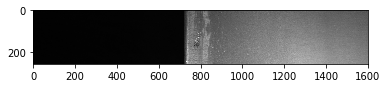

In [55]:
for i in range(0,len(filtered_files)):
    def_draw(filtered_files[i],train_pred_daf,'train_images/','unet_3_class/')
    if i%500 == 0:
        print(i)